### Load `word2vec`

In [1]:
import gensim

model = gensim.models.Word2Vec.load_word2vec_format('word2vec/GoogleNews-vectors-negative300.bin', binary=True)  # C binary format

model

### Which Labels are Part of and *not* Part of `word2vec`?

In [8]:
class_set = '10_1'

classnames = !cat data_files/$class_set/classnames

for classname in classnames:
    try:
        model[classname]
        
        print '{} is IN word2vec!'.format(classname)
    except KeyError:
        print '{} NOT in word2vec!'.format(classname)

sax, saxophone NOT in word2vec!
limousine, limo NOT in word2vec!
shovel is IN word2vec!
baseball is IN word2vec!
meerkat, mierkat NOT in word2vec!
church, church building NOT in word2vec!
yurt is IN word2vec!
obelisk is IN word2vec!
bluetick (dog) NOT in word2vec!
mushroom is IN word2vec!


### Take First Word in Each of the Labels...

In [9]:
classnames = [classname.split()[0] for classname in classnames]
classnames = [classname.split(',')[0] for classname in classnames]

classnames

['sax',
 'limousine',
 'shovel',
 'baseball',
 'meerkat',
 'church',
 'yurt',
 'obelisk',
 'bluetick',
 'mushroom']

### Get `word2vec` Embeddings for Each Label

In [10]:
embeddings = np.array([model[classname] for classname in classnames])

embeddings.shape

(10, 300)

### Affinity Matrix

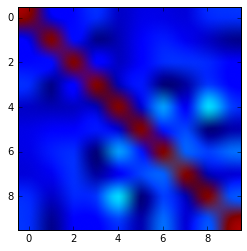

In [11]:
from scipy import spatial

affinity_matrix = np.array([[model.similarity(c1, c2) for c2 in classnames] for c1 in classnames])

plt.imshow(affinity_matrix, interpolation='spline16')

### Write Affinity Matix to Disk

In [6]:
from soft_labels import write_matrix_to_file

write_matrix_to_file('w2v_aff.txt', affinity_matrix)

### Which Words is Each Word Most Similar To?

In [12]:
for classname in classnames:
    print 'Words most similar to {}...'.format(classname.upper())
    print
    
    for similar_word, score in model.most_similar(classname):
        print similar_word, score
        
    print

Words most similar to SAX...

saxophone 0.842030107975
tenor_sax 0.810840785503
saxophonist 0.77451467514
alto_sax 0.763413906097
tenor_saxophone 0.754911899567
guitar 0.753402173519
trombone 0.752578020096
harmonica 0.74691337347
vibraphone 0.737318515778
baritone_sax 0.723803341389

Words most similar to LIMOUSINE...

limo 0.823372483253
limousines 0.698554873466
stretch_limo 0.653646588326
limos 0.651788949966
chauffeured 0.632141113281
chauffeur_driven 0.626999974251
chauffeur 0.618360757828
limosine 0.616405367851
chauffeured_limousine 0.599939584732
Mercedes_limousine 0.596711397171

Words most similar to SHOVEL...

shovels 0.76616358757
snowblow 0.66142308712
backhoe 0.581168711185
shoveling 0.568747699261
Wes_Velker 0.550619006157
shovels_rakes 0.549147307873
posthole_digger 0.547494292259
trowel 0.545029520988
mattock 0.544031858444
snow_blower 0.543143570423

Words most similar to BASEBALL...

Baseball 0.754246890545
softball 0.708990573883
ballplayers 0.676147460938
basketba

### Which Labels is Each Label Most Similar To?

In [13]:
for i, class_order in enumerate(np.argsort(-affinity_matrix)):
    print '{}: {}'.format(classnames[i], ','.join(np.array(classnames)[class_order[1:]]))
    print

sax: mushroom,baseball,bluetick,shovel,yurt,church,limousine,obelisk,meerkat

limousine: yurt,shovel,church,obelisk,sax,bluetick,meerkat,mushroom,baseball

shovel: obelisk,yurt,bluetick,limousine,sax,mushroom,baseball,church,meerkat

baseball: bluetick,sax,church,mushroom,shovel,meerkat,obelisk,limousine,yurt

meerkat: bluetick,yurt,mushroom,obelisk,church,sax,shovel,baseball,limousine

church: obelisk,yurt,baseball,shovel,limousine,sax,meerkat,mushroom,bluetick

yurt: meerkat,mushroom,obelisk,bluetick,shovel,limousine,church,sax,baseball

obelisk: yurt,church,shovel,meerkat,limousine,sax,mushroom,bluetick,baseball

bluetick: meerkat,mushroom,yurt,baseball,shovel,sax,limousine,obelisk,church

mushroom: yurt,bluetick,meerkat,sax,baseball,shovel,obelisk,church,limousine



### How Diffuse are the Similarity Scores?

Some wins:

- Animals seem to be closest to other animals
    - `meerkat` to `bluetick` and `ant`
    - `ant` to `meerkat`
- Structures most similar to other structures
    - `church` to `obelisk`
    
Some losses:

- `yurt` is most similar to `meerkat`

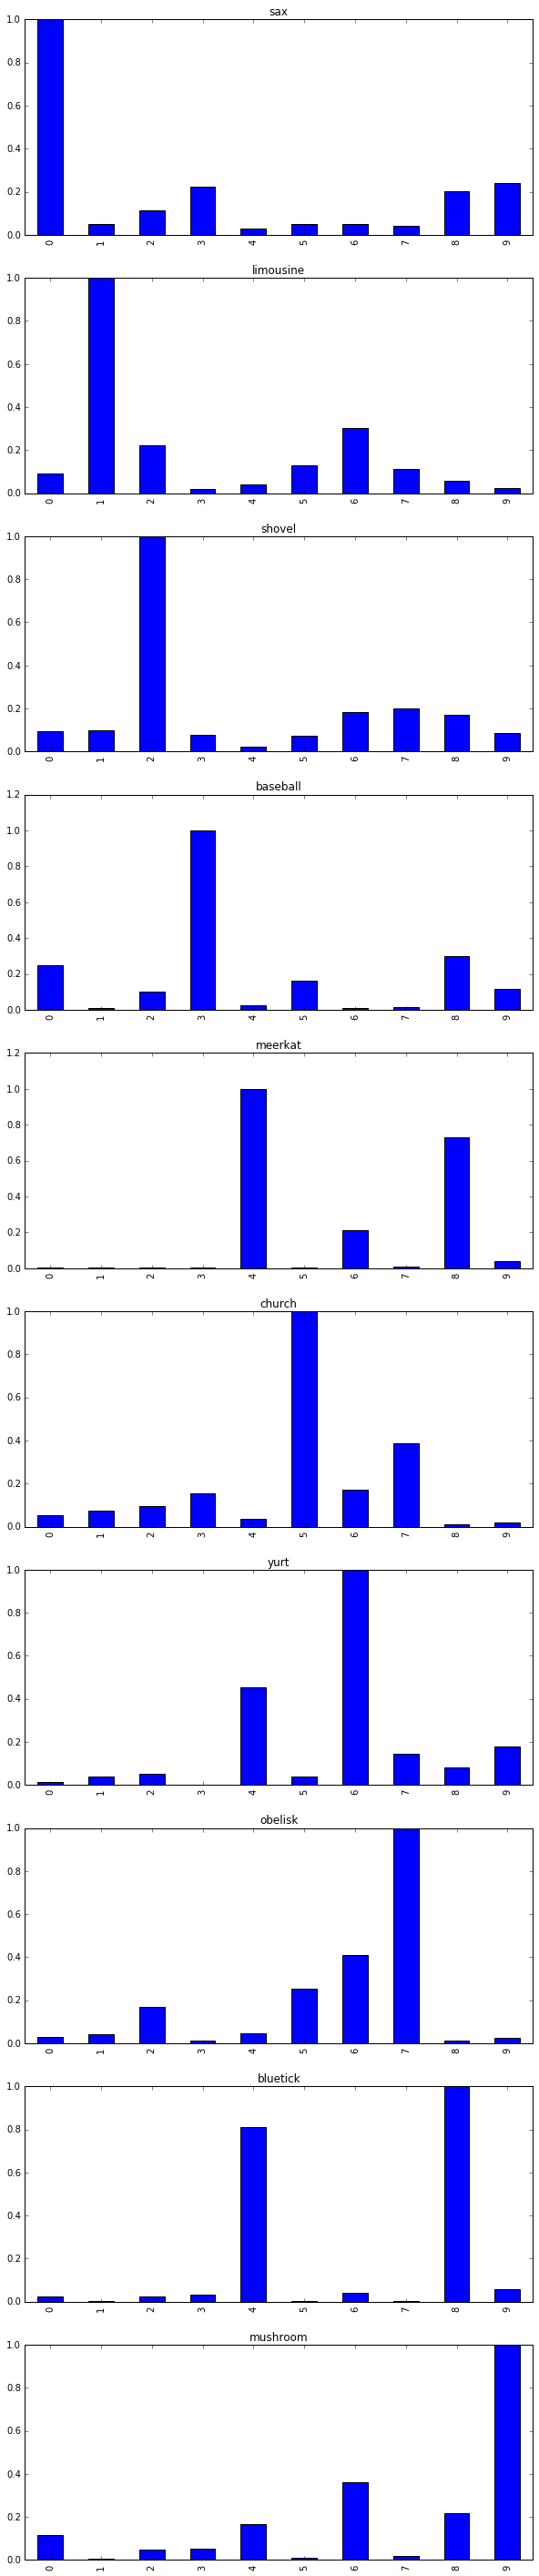

In [25]:
def threshold_distribution(affinity_matrix, divide_times=0):
    """Take class similarity scores along the rows and normalize up to (potentially) sub-1.0"""
    
    num_classes = len(classnames)
    
    fig, axes_list = plt.subplots(num_classes, figsize=[10, 50])

    for i, (label_scores, axes) in enumerate(zip(affinity_matrix, axes_list)):
        norm_term = label_scores.sum()
        norm_term -= label_scores[i]
        
        label_scores /= norm_term
        label_scores[i] *= norm_term
    
        for _ in range(divide_times):
            label_scores /= 2
            label_scores[i] *= 2
            
        axes = pd.Series(label_scores).plot(kind='bar', title=classnames[i], ax=axes)

        yield label_scores

from soft_labels import scale_affinity_matrix_zhao

af = scale_affinity_matrix_zhao(affinity_matrix, decay_factor=20)

af0 = np.array(list(threshold_distribution(af, divide_times=0)))

### Dump Affinity Matrices

In [71]:
import pickle

pickle.dump(af0, open('data_files/{}/aff_w2v_1.0.p'.format(class_set), 'wb'))
pickle.dump(af1, open('data_files/{}/aff_w2v_0.5.p'.format(class_set), 'wb'))
pickle.dump(af2, open('data_files/{}/aff_w2v_0.25.p'.format(class_set), 'wb'))

# Stop Here!

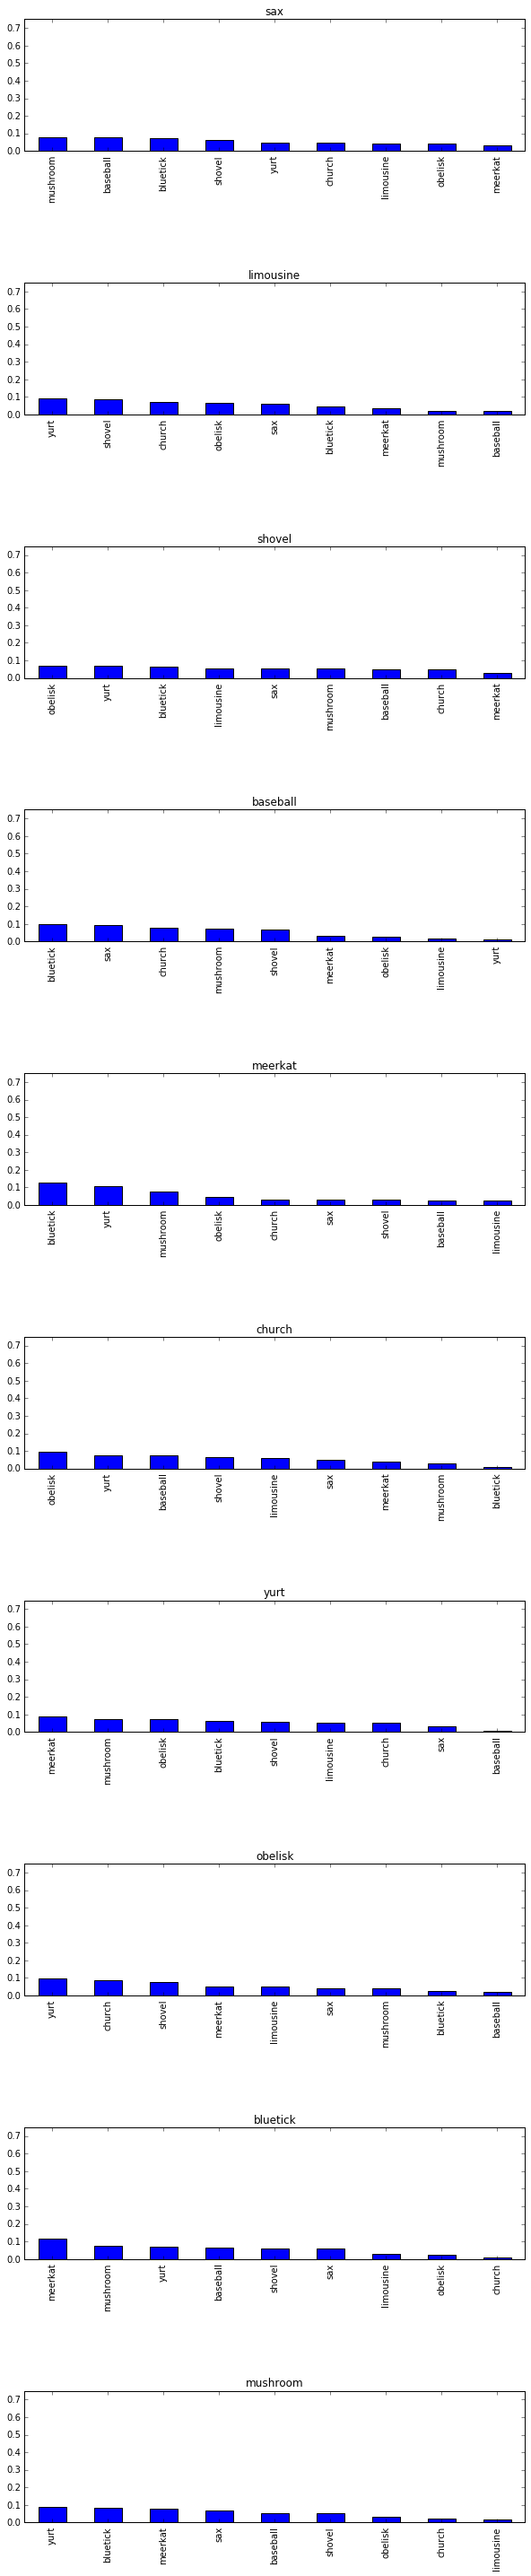

In [22]:
def plot_distribution(affinity_matrix, divide_times=1):

    num_classes = len(classnames)

    fig, axes_list = plt.subplots(num_classes, figsize=[10, 50])

    for label_scores, label_idxs, axes in zip(np.sort(-affinity_matrix), np.argsort(-affinity_matrix), axes_list):
        label_scores = -label_scores[1:] / -label_scores[1:].sum()
        
        for _ in range(divide_times):
            label_scores /= 2

        axes = pd.Series(label_scores, index=np.array(classnames)[label_idxs[1:]]).plot(kind='bar', title=classnames[label_idxs[0]], ax=axes)
        
        axes.set_ylim([0, .75])

    fig.subplots_adjust(hspace=1.)

plot_distribution(affinity_matrix)